In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.utils import add_remaining_self_loops

import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
import torch.nn as nn

from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from graphFeatureSelect.utils import get_adata
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [2]:
def train_gnn(model, optimizer, data, criterion):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss



def val_gnn(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return val_acc


def test_gnn(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

def test_gnn_return_correct(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    return test_correct, pred[data.test_mask], data.y[data.test_mask]



def training_loop(model, data, total_epoch):
    optimizer_self = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    for epoch in range(1, total_epoch + 1):
        loss = train_gnn(model, optimizer_self, data, criterion)
        val_acc = test_gnn(model, data)
        if epoch % 200 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val acc: {val_acc:.4f}")
        loss_list.append(loss.detach().numpy())
    model.eval()
    val_acc = test_gnn(model, data)
    print(f"Model accuracy: {val_acc:.4f}")
    return val_acc, loss_list

In [41]:
def train_gnn_xyz(model, optimizer, data, criterion):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index, data.xyz)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test_gnn_xyz(model, data):
    model.eval()
    out = model(data.x, data.edge_index, data.xyz)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

def training_loop_xyz(model, data, total_epoch):
    optimizer_self = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    for epoch in range(1, total_epoch + 1):
        loss = train_gnn_xyz(model, optimizer_self, data, criterion)
        val_acc = test_gnn_xyz(model, data)
        if epoch % 200 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val acc: {val_acc:.4f}")
        loss_list.append(loss.detach().numpy())
    model.eval()
    val_acc = test_gnn_xyz(model, data)
    print(f"Model accuracy: {val_acc:.4f}")
    return val_acc, loss_list

In [30]:
# residual connection version 3
# simplest
class GAT3(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.hidden_channels = hidden_channels
        self.conv1 = GATv2Conv(num_features, hidden_channels, heads = 8, concat = False)
        self.conv2 = GATv2Conv(hidden_channels, num_classes, heads = 8, concat = False)
        self.lin1 = nn.Linear(num_features, num_classes)

        self.dropout = nn.Dropout(0.25)
    def forward(self, x, edge_index):
        residual1 = self.lin1(x)
        
        out = self.conv1(x, edge_index)
        out = out.relu()
        out = self.dropout(out)
        
        out = self.conv2(out, edge_index)
        out = out + residual1

        return out

In [49]:
# residual connection version 3 with xyz
# simplest
class GAT3xyz(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.hidden_channels = hidden_channels
        self.conv1 = GATv2Conv(num_features, hidden_channels, heads = 8, concat = False)
        self.conv2 = GATv2Conv(hidden_channels, num_classes, heads = 8, concat = False)
        self.lin1 = nn.Linear(num_features, num_classes)
        self.lin2 = nn.Linear(2, num_classes)


        self.dropout = nn.Dropout(0.25)
    def forward(self, x, edge_index, xyz):
        residual1 = self.lin1(x)
        out = self.conv1(x, edge_index)
        out = out.relu()
        out = self.dropout(out)
        
        out = self.conv2(out, edge_index)
        out = out + residual1 + self.lin2(xyz)

        return out

In [34]:
adata = get_adata("../data/VISp.h5ad")

# selecting 1 layer of anndata
# use supertype not subclass
display(adata.obs[["brain_section_label", "z_section"]].sort_values("z_section").value_counts().to_frame().head(4))
one_sec = adata[adata.obs["z_section"] == 5.0, :]
df = one_sec.obs.copy()
num_nodes = df.shape[0]
cell_type = "supertype"

# creating train/test masks
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Keep cells who are participants in the multilayer graph (more than 1 connection)
train_idx, test_idx = next(skf.split(np.arange(df.shape[0]), df[cell_type].values))

train_mask = np.zeros(df.shape[0], dtype=bool)
train_mask[train_idx] = True
train_mask = torch.tensor(train_mask, dtype=torch.bool)

test_mask = np.zeros(df.shape[0], dtype=bool)
test_mask[test_idx] = True
test_mask = torch.tensor(test_mask, dtype=torch.bool)

labels = torch.tensor(df[cell_type].cat.codes.values, dtype=torch.long)



/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,,count
brain_section_label,z_section,
C57BL6J-638850.30,5.0,9242
C57BL6J-638850.29,4.8,8713
C57BL6J-638850.28,4.6,7780
C57BL6J-638850.31,5.4,6939


/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [35]:
# constructing edges with nearest neighbors
k = 10
X = df[["x_reconstructed", "y_reconstructed"]]

A = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

edgelist_knn = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_knn = add_remaining_self_loops(edgelist_knn.T)[0]

edgelist_self = torch.tensor([[i, i] for i in range(num_nodes)])
edgelist_self = edgelist_self.T

In [65]:
xy = torch.tensor(X.values).type(torch.float32)

In [66]:
one_sec_x = torch.tensor(one_sec.X.todense(), dtype=torch.float)
data_knn = Data(x=one_sec_x, edge_index=edgelist_knn, y=labels, train_mask=train_mask, test_mask=test_mask)
data_knn_xyz = Data(x=one_sec_x, edge_index=edgelist_knn, xyz = xy, y=labels, train_mask=train_mask, test_mask=test_mask)

data_self = Data(x=one_sec_x, edge_index=edgelist_self, y=labels, train_mask=train_mask, test_mask=test_mask)

In [67]:
GAT_knn = GAT(hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0])
GAT2_knn = GAT2(hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0])
GAT3_knn = GAT3(hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0])
GAT3_xyz = GAT3xyz(hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0])
GAT_self = GAT(hidden_channels=32, num_features=data_self.x.shape[1], num_classes=torch.unique(data_self.y).size()[0])

In [17]:
print(data_knn.x.shape[1], torch.unique(data_knn.y).size()[0])

550 94


Epoch: 200, Loss: 0.0546, Val acc: 0.8767
Epoch: 400, Loss: 0.0236, Val acc: 0.8832
Epoch: 600, Loss: 0.0200, Val acc: 0.8864
Epoch: 800, Loss: 0.0175, Val acc: 0.8864
Epoch: 1000, Loss: 0.0139, Val acc: 0.8697
Model accuracy: 0.8697


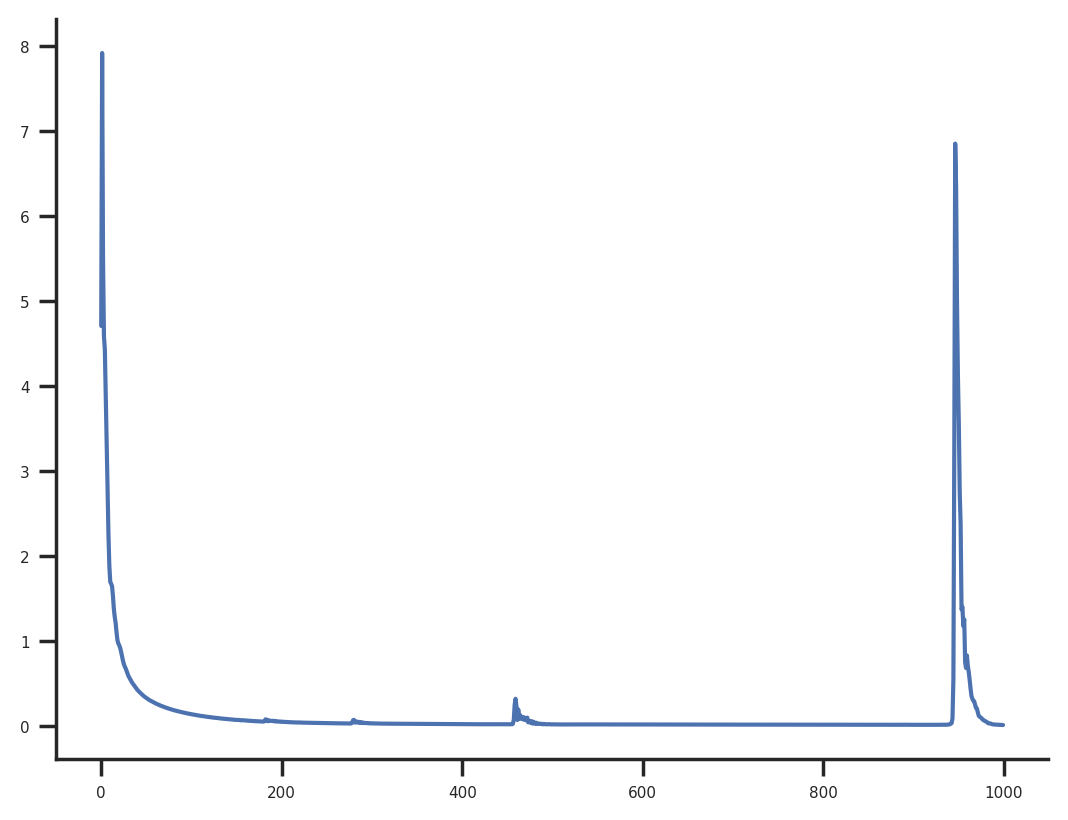

In [15]:
# GAT KNN
val_acc, loss_list = training_loop(GAT_knn, data_knn, 1000)
plt.plot(loss_list)

Epoch: 200, Loss: 0.0522, Val acc: 0.8826
Epoch: 400, Loss: 0.0394, Val acc: 0.8875
Epoch: 600, Loss: 0.0349, Val acc: 0.8880
Epoch: 800, Loss: 0.0329, Val acc: 0.8897
Epoch: 1000, Loss: 0.0317, Val acc: 0.8891
Model accuracy: 0.8891


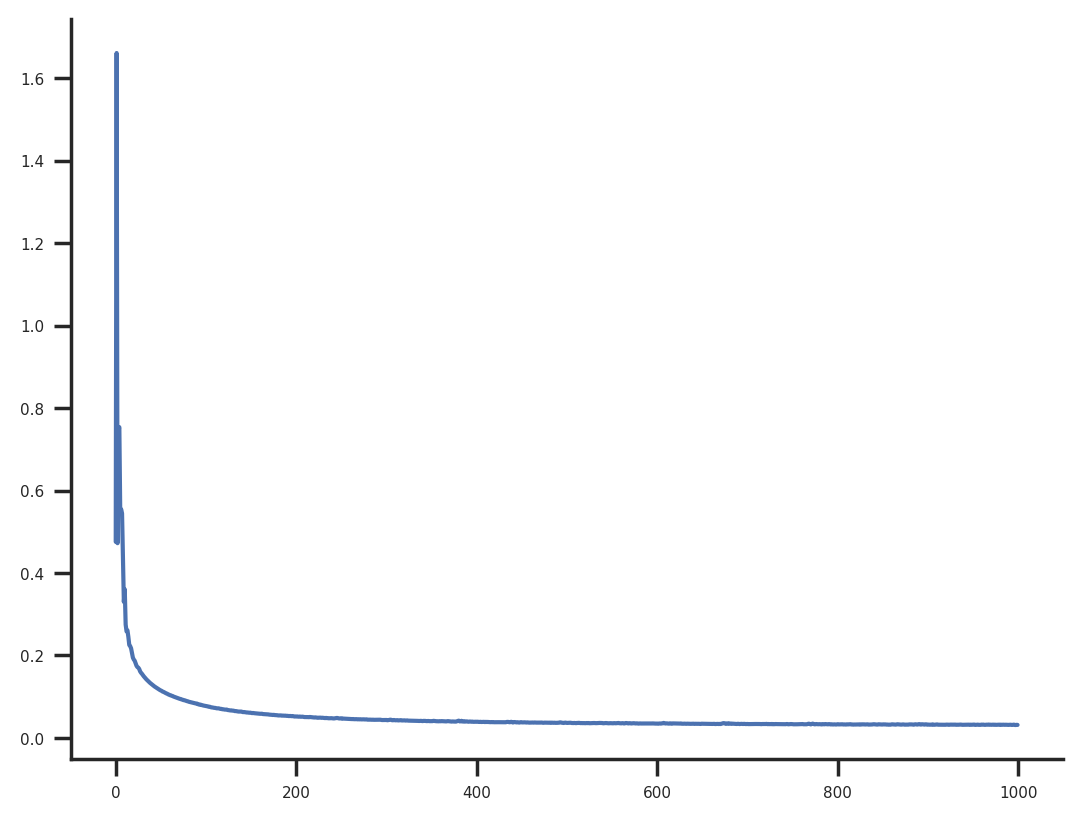

In [16]:
# GAT KNN 2
val_acc, loss_list = training_loop(GAT2_knn, data_knn, 1000)
plt.plot(loss_list)

Epoch: 200, Loss: 0.0591, Val acc: 0.8821
Epoch: 400, Loss: 0.0430, Val acc: 0.8891
Epoch: 600, Loss: 0.0377, Val acc: 0.8897
Epoch: 800, Loss: 0.0352, Val acc: 0.8902
Epoch: 1000, Loss: 0.0339, Val acc: 0.8897
Model accuracy: 0.8897


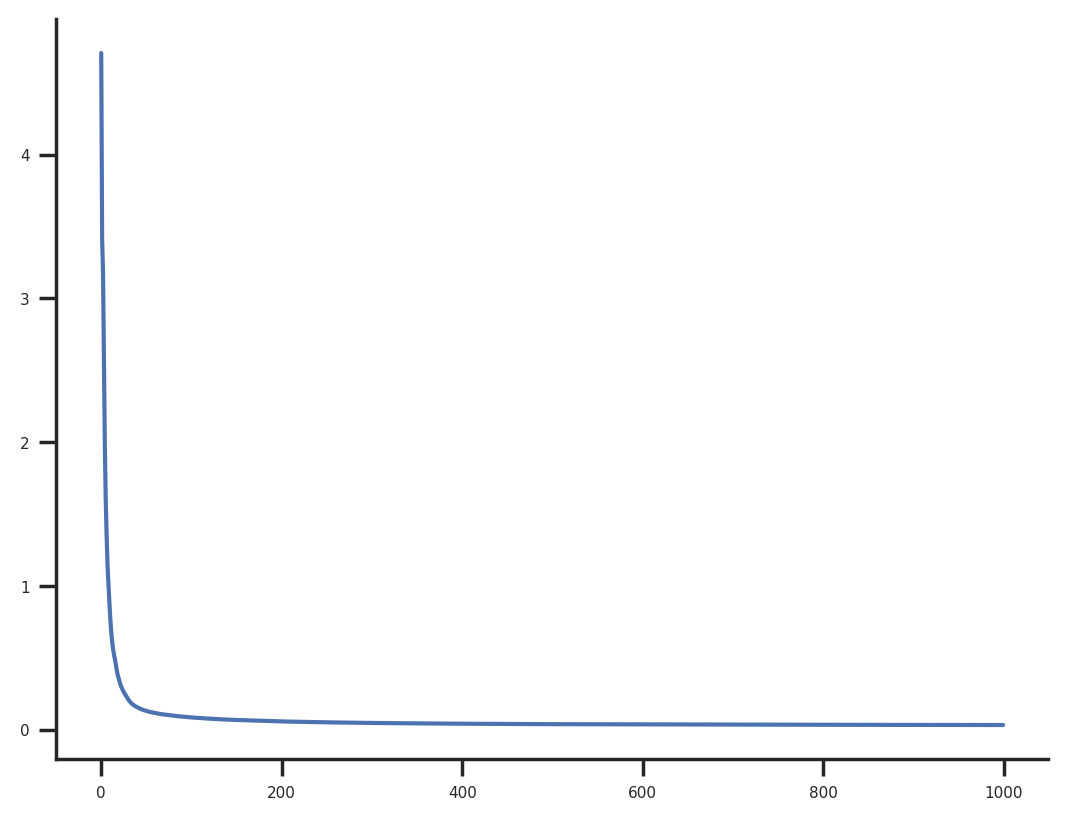

In [18]:
# GAT KNN 3
val_acc, loss_list = training_loop(GAT3_knn, data_knn, 1000)
plt.plot(loss_list)

Epoch: 200, Loss: 0.0610, Val acc: 0.8767
Epoch: 400, Loss: 0.0436, Val acc: 0.8848
Epoch: 600, Loss: 0.0373, Val acc: 0.8864
Epoch: 800, Loss: 0.0337, Val acc: 0.8848
Epoch: 1000, Loss: 0.0323, Val acc: 0.8843
Model accuracy: 0.8843


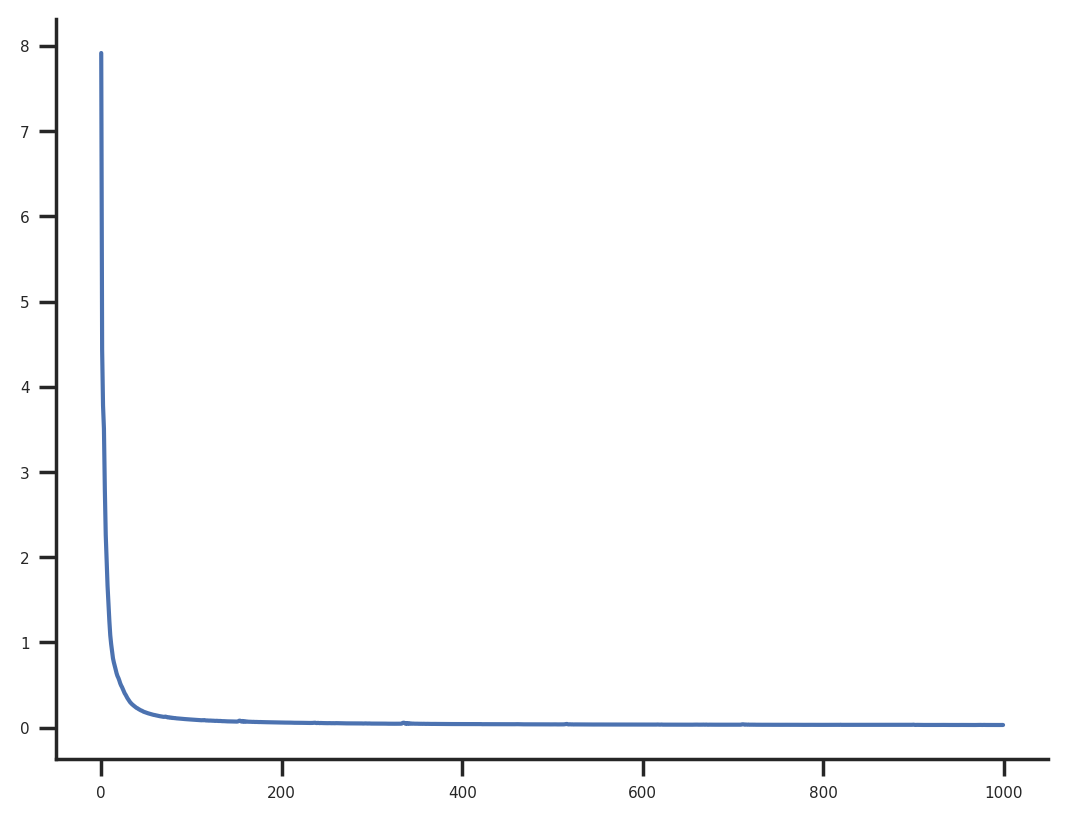

In [68]:
# GAT KNN 3 xyz
val_acc, loss_list = training_loop_xyz(GAT3_xyz, data_knn_xyz, 1000)
plt.plot(loss_list)

In [25]:
torch.save(GAT3_knn.state_dict(), "GAT3_1slice.pth")

In [31]:
# GAT3 model with edges thresholded based on gene expression cosine similarity
k = 50
A = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

edgelist_knn = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_knn = add_remaining_self_loops(edgelist_knn.T)[0]

from sklearn.metrics.pairwise import cosine_similarity

# cos similarity matrix based on gene expression
gene_expr_similarity = cosine_similarity(one_sec.X)

from scipy import sparse

gene_expr_similarity_csr = sparse.csr_matrix(gene_expr_similarity )

A[gene_expr_similarity_csr < 0.9] = 0
print(A.count_nonzero())
A.eliminate_zeros()

edgelist_cos = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_cos = add_remaining_self_loops(edgelist_cos.T)[0]
data_cos = Data(x=one_sec_x, edge_index=edgelist_cos, y=labels, train_mask=train_mask, test_mask=test_mask)
model_cos = GAT3(hidden_channels=32, num_features=data_cos.x.shape[1], num_classes=torch.unique(data_cos.y).size()[0])


/tmp/ipykernel_4123188/226654070.py:16: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  A[gene_expr_similarity_csr < 0.9] = 0
/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


1031


Epoch: 200, Loss: 0.0592, Val acc: 0.8816
Epoch: 400, Loss: 0.0436, Val acc: 0.8902
Epoch: 600, Loss: 0.0381, Val acc: 0.8897
Epoch: 800, Loss: 0.0354, Val acc: 0.8897
Epoch: 1000, Loss: 0.0340, Val acc: 0.8886
Model accuracy: 0.8886


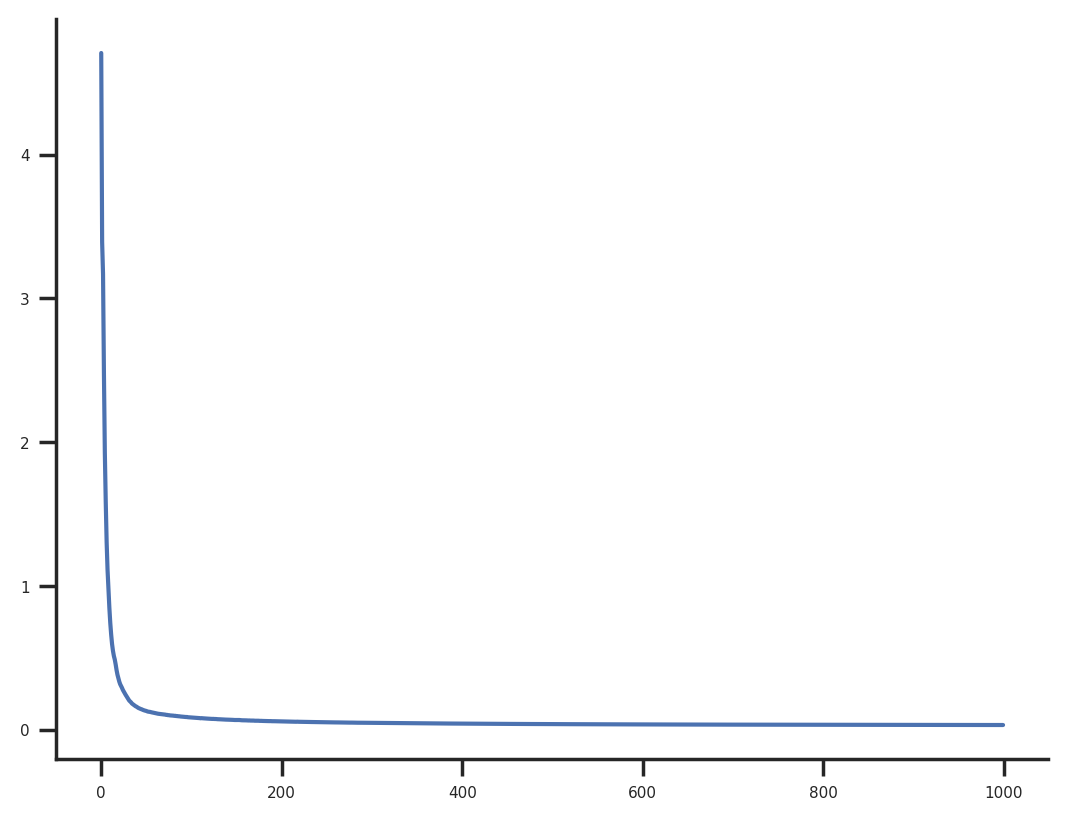

In [23]:
val_acc, loss_list = training_loop(model_cos, data_cos, 1000)
plt.plot(loss_list)

In [19]:
correct_test, pred, ground_truth = test_gnn_return_correct(GAT3_knn, data_knn)
incorrect_test = np.array([not elem for elem in correct_test])

In [20]:
# get "full data" indices of test_mask
test_mask_ind = torch.nonzero(data_knn.test_mask)

In [21]:
# get "full data" indices of incorrect_test using the above
incorrect_ind = test_mask_ind[incorrect_test]
np.unique(labels[torch.squeeze(incorrect_ind).tolist()].tolist())

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 20,
       21, 22, 23, 24, 26, 28, 30, 31, 32, 33, 35, 36, 40, 41, 42, 43, 46,
       51, 53, 57, 58, 60, 61, 62, 63, 66, 69, 70, 72, 73, 75, 76, 79, 80,
       81, 82, 83, 84, 85, 87, 88, 90, 91, 93])

In [22]:
# distribution of cell types for cells that were incorrectly predicted
pd.DataFrame(labels[torch.squeeze(incorrect_ind).tolist()].tolist()).value_counts()


0 
16    20
20    18
12    18
18    14
79     9
      ..
51     1
57     1
58     1
61     1
93     1
Name: count, Length: 61, dtype: int64

In [131]:
edgelist_incorrect = {}
for ind in incorrect_ind:
    v0 = int(ind)
    v1_list = np.nonzero(A[v0].toarray())[1]
    edgelist_incorrect[v0] = v1_list
different_v1_per_v0 = {}

for key, val in edgelist_incorrect.items():
    label0 = labels[key]
    label1_list = labels[val].tolist()
    label0_cnt = label1_list.count(label0)
    different_v1_per_v0[label0] = len(label1_list) - label0_cnt


In [134]:
# For each incorrectly predicted cell, count the number of distinct celltypes (From itself) it is connected to (duplicates allowed)
# High heterophilly
pd.DataFrame(list(different_v1_per_v0.values())).value_counts()

0 
10    99
9     30
8     22
7     17
6     16
5     10
1      3
4      3
2      2
3      2
Name: count, dtype: int64

In [82]:
# MLP classifier to predict celltypes (baseline)
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(one_sec_x[train_mask], labels[train_mask])

MLPClassifier()

In [83]:
clf.score(one_sec_x[test_mask], labels[test_mask])

0.8761492698756085

In [135]:
# of cells that are incorrectly predicted for both GAT3 and Baseline.
# This is a majority of cells that were incorrectly predicted for both models (around 220 each?)
# Could reasonably hypothesize that these cells have bad gene expression
# or maybe these cells are minority cases (skewed dataset) --> test and plot this
clf_predict = clf.predict(one_sec_x[test_mask])
clf_incorrect = clf_predict != np.array(labels[test_mask])
incorrect_clf_ind = test_mask_ind[clf_incorrect]
incorrect_clf_ind_set = set(np.squeeze(np.array(incorrect_clf_ind)).tolist())
incorrect_ind_set = set(np.squeeze(np.array(incorrect_ind)).tolist())
intersection_incorrect = incorrect_clf_ind_set.intersection(incorrect_ind_set)
len(intersection_incorrect)

169